# Second Home Assignment AA (2022/2023)
### Group: 59

Importar dados

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [247]:
biog = pd.read_csv("biodegradable_a.csv", sep=",")

X = biog.values[:, 0:41]
y = biog["Biodegradable"].values

y[y == "RB"] = 1.0
y[y == "NRB"] = 0.0

X_train_IVS, X_IVS, y_train_IVS, y_IVS = train_test_split(X, y.astype(float), test_size=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train_IVS, y_train_IVS, test_size=0.25, random_state=0)

X_cols = biog.columns[0:41]

countRB = 0
countNRB = 0
for i in y:
    if(i == 1): countRB += 1
    elif(i == 0): countNRB += 1

print(countRB, countNRB)

# pd.DataFrame(X, columns=X_cols)

3825 739


Verificar valores em falta

In [248]:
# check number of missing values in each column.

# dataset without lines with NaN values
biog_nan = biog.dropna()
#print(len(biog_nan))

print("No. of rows original dataset = {}".format(len(biog)))
print("No. of rows without NaN = {} ({}%)".format(len(biog_nan), round(len(biog_nan) / len(biog) * 100)))


# check number of missing values in each column.
missValues = biog.isna().sum()

missValues = missValues.to_frame()
print("Threshold number of missing values per column = {} (15%)".format(str(round(0.15 * len(X)))))

# print(missValues)

No. of rows original dataset = 4564
No. of rows without NaN = 889 (19%)
Threshold number of missing values per column = 685 (15%)


Escalar os dados (Standard Scaler)

In [249]:
import statistics

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Metodo de Imputação

In [250]:
useMean = [0, 1, 7, 11, 12, 13, 14, 21, 26, 27, 38]
useMedian = np.setdiff1d(range(41), useMean)

Imputar dados

In [251]:
# Impute missing values
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

# strategy = mean or median (for numerical data)
imputerMean = SimpleImputer(missing_values = np.nan, strategy = "mean") 
imputerMedian = SimpleImputer(missing_values = np.nan, strategy = "median") 

ct = ColumnTransformer(
    [('mean_imputer', imputerMean, useMean),
     ('median_imputer', imputerMedian, useMedian)]
)

ct.fit(X_train_scaled)

X_train_processed = ct.transform(X_train)
X_test_processed = ct.transform(X_test)

# Feature selection

### Correlation

In [252]:
N, M = X_train.shape

v = np.hstack((y_train.reshape((N, 1)), X_train_processed))

pd.DataFrame(v)
corrMatrix = pd.DataFrame((np.corrcoef(v.T.astype(float))), columns=X_cols.insert(0, "Y")).iloc[0].sort_values()[0:10]

selectedCorr = list(corrMatrix.index)

print(corrMatrix)
print("The 10 selected features are:", selectedCorr)

SdssC      -0.497498
nHDon      -0.453868
nN_N       -0.451105
F02_CN     -0.438829
LOC        -0.420888
Psi_i_1d   -0.411507
F03        -0.400766
SM6_B      -0.389450
F03_CO     -0.375346
SpMax_L    -0.364687
Name: 0, dtype: float64
The 10 selected features are: ['SdssC', 'nHDon', 'nN_N', 'F02_CN', 'LOC', 'Psi_i_1d', 'F03', 'SM6_B', 'F03_CO', 'SpMax_L']


### Random Forest Feature Selection

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


sel = SelectFromModel(RandomForestClassifier(random_state=0), max_features=10)
sel.fit(X_train_processed, y_train)

selectedForest = []
selectedForestIndixes = []

for feature_list_index in sel.get_support(indices=True):
    selectedForestIndixes.append(feature_list_index)
    selectedForest.append(X_cols[feature_list_index])
    print("Feature: ", X_cols[feature_list_index], "| Importance: ", sel.estimator_.feature_importances_[feature_list_index])

Feature:  SpMax_L | Importance:  0.06106725094288645
Feature:  C | Importance:  0.029995472017299595
Feature:  F03 | Importance:  0.03959764601713044
Feature:  SdssC | Importance:  0.09716670008946071
Feature:  LOC | Importance:  0.06300495239999916
Feature:  SM6_L | Importance:  0.053959750360603784
Feature:  F03_CO | Importance:  0.049693961165154
Feature:  nN_N | Importance:  0.052325489347075385
Feature:  nHDon | Importance:  0.053039972681158426
Feature:  nX | Importance:  0.061025657008724164


### StepWise (Forward)

In [254]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

N,M = X_train_processed.shape

dtc = DecisionTreeClassifier(random_state=0)
sfs = SequentialFeatureSelector(dtc, n_features_to_select=10, direction="forward")

sfs.fit(X_train_processed, y_train)

features = sfs.get_support()
ST_for_selected_features = np.arange(M)[features]

print(X_cols[ST_for_selected_features])

Index(['F01', 'SdssC', 'SM6_L', 'F03_CO', 'nN_N', 'nArNO2', 'B01', 'C_026',
       'nHDon', 'nX'],
      dtype='object')


### StepWise (BackWard)

In [255]:
dtc = DecisionTreeClassifier(random_state=0)
sfs = SequentialFeatureSelector(dtc, n_features_to_select=10, direction="backward")

sfs.fit(X_train_processed, y_train)

features = sfs.get_support()
ST_back_selected_features = np.arange(M)[features]

print(X_cols[ST_back_selected_features])

Index(['F01', 'C', 'SdssC', 'SM6_L', 'F03_CO', 'Me', 'nN_N', 'nCrt', 'C_026',
       'nHDon'],
      dtype='object')


Indexes of Features Selected

In [256]:
corr_index = []
rand_forest_index = selectedForestIndixes
step_for_index = list(ST_for_selected_features)
step_back_index = list(ST_back_selected_features)

count = 0
for col in X_cols:
    if col in selectedCorr:
        corr_index.append(count)
    count += 1

print(corr_index)
print(rand_forest_index)
print(step_for_index)
print(step_back_index)

[0, 10, 11, 13, 15, 18, 27, 33, 34, 38]
[0, 7, 10, 11, 13, 14, 15, 18, 34, 40]
[3, 11, 14, 15, 18, 19, 23, 32, 34, 40]
[3, 7, 11, 14, 15, 16, 18, 31, 32, 34]


In [257]:
selec_feat_indexes = [corr_index,
                      rand_forest_index,
                      step_for_index,
                      step_back_index, 
                      range(0, 41)]

selec_feat_names = ["Correlation",
                      "Random Forest",
                      "StepWise For",
                      "StepWise Back", 
                      "No Feature Selection"]

## Modelos

Importar metricas de classificação

In [258]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

### KNN

Feature selection method: Correlation
The best MCC we found was 0.7568 with the hyperparameters {'neighbors': 5, 'weigths': <function gaussian at 0x00000268CEEE25E0>, 'f1Score': 0.9628}
Feature selection method: Random Forest
The best MCC we found was 0.7649 with the hyperparameters {'neighbors': 3, 'weigths': <function gaussian at 0x00000268CEEE25E0>, 'f1Score': 0.9642}
Feature selection method: StepWise For
The best MCC we found was 0.7415 with the hyperparameters {'neighbors': 7, 'weigths': 'distance', 'f1Score': 0.9608}
Feature selection method: StepWise Back
The best MCC we found was 0.7490 with the hyperparameters {'neighbors': 5, 'weigths': 'uniform', 'f1Score': 0.9634}
Feature selection method: No Feature Selection
The best MCC we found was 0.6425 with the hyperparameters {'neighbors': 3, 'weigths': <function gaussian at 0x00000268CEEE25E0>, 'f1Score': 0.9493}

Confusion Matrix of best KNN model
 [[ 90  47]
 [ 11 708]]


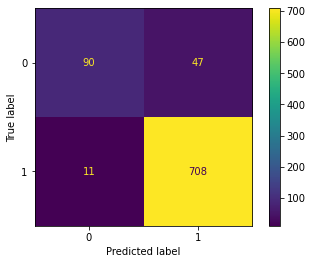

In [259]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import sys


def gaussian(dsts):
    kernel_width = .5
    weights = np.exp(-(dsts**2)/kernel_width)
    return weights

for i in range(5):
    # print(i)
    print("Feature selection method: " + selec_feat_names[i])

    bestMCC = sys.float_info.min
    bestMCCParams = {
            "neighbors": 0,
            "weigths": 0,
            "f1Score": 0
    }

    X_train = X_train_processed[:, selec_feat_indexes[i]]
    X_test = X_test_processed[:, selec_feat_indexes[i]]

    for k in range(3, 11, 2):
        for wei in [gaussian, "distance", "uniform"]:
            knn = KNeighborsClassifier(n_neighbors=k, weights=wei)
            knn.fit(X_train, y_train)
            preds = knn.predict(X_test)
            mcc = matthews_corrcoef(y_test, preds)
            if(mcc > bestMCC):
                bestMCC = mcc
                bestMCCParams["neighbors"] = k
                bestMCCParams["weigths"] = wei
                bestMCCParams["f1Score"] = round(f1_score(y_test, preds), 4)

    print(f"The best MCC we found was {'{:.4f}'.format(bestMCC)} with the hyperparameters {bestMCCParams}")


# FIT BEST KNN MODEL
X_train = X_train_processed[:, step_back_index]
X_test = X_test_processed[:, step_back_index]

knn = KNeighborsClassifier(n_neighbors=bestMCCParams["neighbors"], weights=bestMCCParams["weigths"])
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

bestKNNCM = confusion_matrix(y_test, preds)

print("\nConfusion Matrix of best KNN model\n", bestKNNCM)
cm_display = ConfusionMatrixDisplay(bestKNNCM).plot()

### Random Forest

Feature selection method: Correlation
The best MCC we found was 0.6404 with the hyperparameters {'max_depth': 16, 'min_impurity_decrease': 0.05, 'f1Score': 0.9484}
Feature selection method: Random Forest
The best MCC we found was 0.6745 with the hyperparameters {'max_depth': 12, 'min_impurity_decrease': 0.05, 'f1Score': 0.9532}
Feature selection method: StepWise For
The best MCC we found was 0.6536 with the hyperparameters {'max_depth': 8, 'min_impurity_decrease': 0.05, 'f1Score': 0.952}
Feature selection method: StepWise Back
The best MCC we found was 0.6971 with the hyperparameters {'max_depth': 14, 'min_impurity_decrease': 0.05, 'f1Score': 0.9572}
Feature selection method: No Feature Selection
The best MCC we found was 0.5730 with the hyperparameters {'max_depth': 18, 'min_impurity_decrease': 0.05, 'f1Score': 0.9433}

Confusion Matrix of best RF model
 [[ 81  56]
 [ 19 700]]


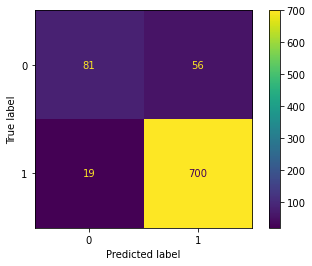

In [260]:
for i in range(5):
        bestMCC = sys.float_info.min
        bestMCCParams = {
                "max_depth": 0,
                "min_impurity_decrease": 0,
                "f1Score": 0
        }

        print("Feature selection method: " + selec_feat_names[i])

        X_train = X_train_processed[:, selec_feat_indexes[i]]
        X_test = X_test_processed[:, selec_feat_indexes[i]]


        for md in range(2, 20, 2):
                for mid in np.arange(0.05, 0.2, 0.05):
                        rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=md, min_impurity_decrease=mid)
                        rf.fit(X_train, y_train)
                        preds = rf.predict(X_test)
                        f1Score = round(f1_score(y_test, preds), 4)
                        mcc = matthews_corrcoef(y_test, preds) 
                        
                        if(mcc > bestMCC):
                                bestMCC = mcc
                                bestMCCParams["max_depth"]= md
                                bestMCCParams["min_impurity_decrease"] = mid
                                bestMCCParams["f1Score"] = f1Score
                                
        
        print(f"The best MCC we found was {'{:.4f}'.format(bestMCC)} with the hyperparameters {bestMCCParams}")


# FIT BEST RF MODEL
X_train = X_train_processed[:, rand_forest_index]
X_test = X_test_processed[:, rand_forest_index]

rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=bestMCCParams["max_depth"], min_impurity_decrease=bestMCCParams["min_impurity_decrease"])
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

bestRFCM = confusion_matrix(y_test, preds)
print("\nConfusion Matrix of best RF model\n", bestRFCM)
cm_display = ConfusionMatrixDisplay(bestRFCM).plot()

### Bagging Classifier

Feature selection method: Correlation
The best MCC we found was 0.6372 with the hyperparameters {'n_estimators': 4, 'f1Score': 0.9415}
Feature selection method: Random Forest
The best MCC we found was 0.6941 with the hyperparameters {'n_estimators': 2, 'f1Score': 0.9514}
Feature selection method: StepWise For
The best MCC we found was 0.7349 with the hyperparameters {'n_estimators': 4, 'f1Score': 0.9613}
Feature selection method: StepWise Back
The best MCC we found was 0.7218 with the hyperparameters {'n_estimators': 4, 'f1Score': 0.9572}
Feature selection method: No Feature Selection
The best MCC we found was 0.7406 with the hyperparameters {'n_estimators': 2, 'f1Score': 0.9619}

Confusion Matrix of best Bagging model
 [[100  37]
 [ 24 695]]


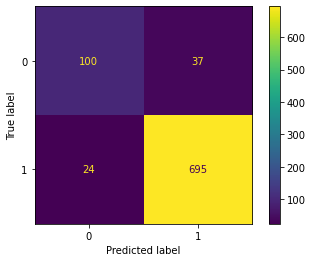

In [261]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

for i in range(5):
    print("Feature selection method: " + selec_feat_names[i])

    X_train = X_train_processed[:, selec_feat_indexes[i]]
    X_test = X_test_processed[:, selec_feat_indexes[i]]

    bestMCC = sys.float_info.min
    bestMCCParams = {
                "n_estimators": 0,
                "f1Score": 0
        }

    for n in range(2, 10, 2):
        bag = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=n, random_state=22)
        bag.fit(X_train, y_train)
        preds = bag.predict(X_test)
        mcc = matthews_corrcoef(y_test, preds)

        if(bestMCC < mcc):
            bestMCC = mcc
            bestMCCParams["n_estimators"] = n
            bestMCCParams["f1Score"] =  round(f1_score(y_test, preds), 4)


    print(f"The best MCC we found was {'{:.4f}'.format(bestMCC)} with the hyperparameters {bestMCCParams}")


# FIT BEST Bagging MODEL
X_train = X_train_processed[:, step_for_index]
X_test = X_test_processed[:, step_for_index]

bag = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=bestMCCParams["n_estimators"], random_state=22)
bag.fit(X_train, y_train)
preds = bag.predict(X_test)

bestBGCM = confusion_matrix(y_test, preds)
print("\nConfusion Matrix of best Bagging model\n", bestBGCM)
cm_display = ConfusionMatrixDisplay(bestBGCM).plot()

## Fitting and validating the best model 

(KNN | Random Forest Feature Selection | Gaussian | k=3)

Our Selected Model is a KNN, where k=3, using features selected with a Random Forest and a Gaussian weight function: 

The MCC is:  0.8184
The Confusion Matrix is: 
 [[151  35]
 [ 20 935]]


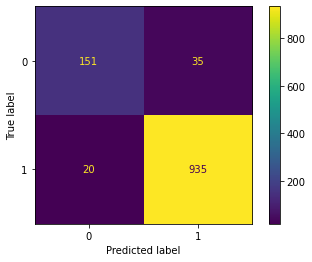

In [262]:
scaler = StandardScaler()
scaler.fit(X_train_IVS)

X_train_IVS_scaled = scaler.transform(X_train_IVS)
X_IVS_scaled = scaler.transform(X_IVS)

imputerMean = SimpleImputer(missing_values = np.nan, strategy = "mean") 
imputerMedian = SimpleImputer(missing_values = np.nan, strategy = "median") 

ct = ColumnTransformer(
    [('mean_imputer', imputerMean, useMean),
     ('median_imputer', imputerMedian, useMedian)]
)

ct.fit(X_train_IVS_scaled)

X_train_IVS_processed = ct.transform(X_train_IVS_scaled)[:, rand_forest_index]
X_IVS_processed = ct.transform(X_IVS_scaled)[:, rand_forest_index]


knn = KNeighborsClassifier(n_neighbors=3, weights=gaussian)
knn.fit(X_train_IVS_processed, y_train_IVS)

preds = knn.predict(X_IVS_processed)

mcc = matthews_corrcoef(y_IVS, preds)
cm = confusion_matrix(y_IVS, preds)

print("Our Selected Model is a KNN, where k=3, using features selected with a Random Forest and a Gaussian weight function: \n")
print("The MCC is: ", round(mcc, 4))
print("The Confusion Matrix is: \n", cm)

cm_display = ConfusionMatrixDisplay(cm).plot()